# Working with Great Lakes Sea Surface Temperature Data from Google Cloud

This notebook will guide you through downloading a NetCDF file from Google Cloud Storage,
opening it with xarray, and performing some basic examinations and plots.

In [ ]:
!pip install matplotlib gcsfs pandas numpy xarray

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import gcsfs # Google Cloud Storage File System
import pandas as pd
import numpy as np

# 1. Setup and Download the Dataset

In [3]:
# We'll use the 'curl' command-line tool to download the file directly.

# Define the Google Cloud Storage (GCS) path to your NetCDF file
gcs_file_path = "gs://great-lakes-osd/glos_obs/gl_temp_data_cleaned.nc"

# Define a local path where you want to save the NetCDF file
# You can change this to any directory on your computer.
local_data_dir = "./data/" # Creates a 'data' folder in the current directory if it doesn't exist
local_file_name = "gl_temp_data_cleaned.nc"
local_file_path = os.path.join(local_data_dir, local_file_name)

# Create the local data directory if it doesn't exist
os.makedirs(local_data_dir, exist_ok=True)

print(f"Attempting to download data from: {gcs_file_path}")
print(f"Saving to local path: {local_file_path}")

# Initialize the Google Cloud Storage file system
# If running in Google Colab, you may likely need to authenticate your Google account
# in a separate cell BEFORE running this download step.
# For Google Colab, run:
# from google.colab import auth
# auth.authenticate_user()
# (Then follow the prompts in the browser)
# (That being said, I've had a hard time getting GCP to play nice with Google Colab...)

try:
    fs = gcsfs.GCSFileSystem()
    # Use the 'get' method to download the file from GCS to your local machine.
    # This might take a few minutes as the file is ~800MB.
    fs.get(gcs_file_path, local_file_path)
    print("Download complete!")
except Exception as e:
    print(f"Error downloading file: {e}")
    print("Please ensure you have:")
    print("1. Installed 'gcsfs' (pip install gcsfs)")
    print("2. Proper authentication set up for Google Cloud (e.g., 'gcloud auth login' on your machine,")
    print("   or 'from google.colab import auth; auth.authenticate_user()' in Google Colab).")

Attempting to download data from: gs://great-lakes-osd/glos_obs/gl_temp_data_cleaned.nc
Saving to local path: ./data/gl_temp_data_cleaned.nc
Download complete!


# 2. Open and Examine the Dataset

In [4]:
print(f"\nOpening dataset from: {local_file_path}")
# Open the dataset using xarray.
# Xarray is smart enough to use Dask for lazy loading, meaning it won't load
# the entire ~800MB file into your computer's memory all at once.
# Data will only be loaded when you explicitly ask for a computation (like plotting).
ds = xr.open_dataset(local_file_path)

# Print the dataset to see its structure, dimensions, coordinates, and data variables.
print(ds)


Opening dataset from: ./data/gl_temp_data_cleaned.nc
<xarray.Dataset> Size: 828MB
Dimensions:        (obs: 20693414)
Coordinates:
    time           (obs) datetime64[ns] 166MB ...
    longitude      (obs) float64 166MB ...
    latitude       (obs) float64 166MB ...
    index          (obs) int64 166MB ...
Dimensions without coordinates: obs
Data variables:
    temperature_k  (obs) float64 166MB ...
Attributes:
    description:  Great Lakes In-situ Sea Surface Temperature Measurements (a...
    source:       GLOS Data Warehouse
    history:      Processed to Xarray/NetCDF from pipe-delimited text files w...


# 3. Basic Visualization

Since this dataset contains millions of individual observations,
directly plotting all of them at once can be overwhelming or crash your system.
We'll focus on a few common ways to summarize and visualize the data.

### 3.1 Temperature Distribution Histogram


Generating temperature distribution histogram...


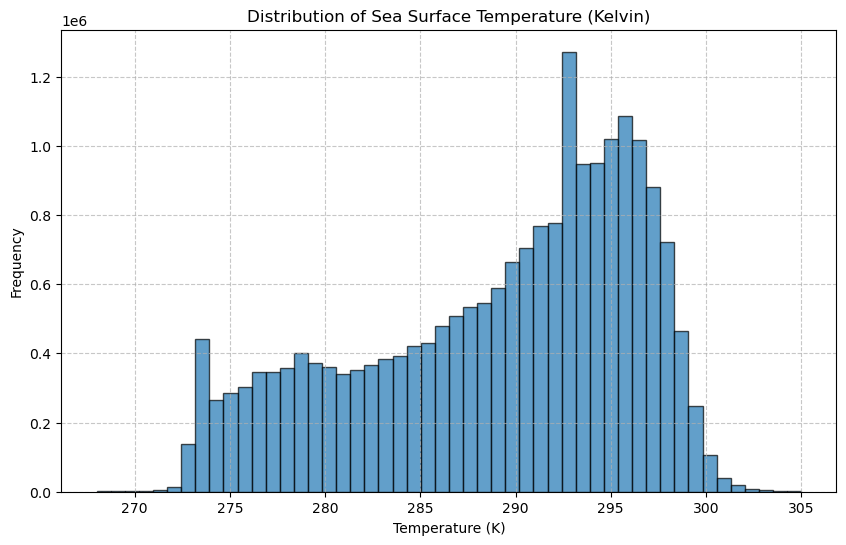

Histogram complete.


In [5]:
# A histogram shows the distribution of temperature values across all observations.
print("\nGenerating temperature distribution histogram...")
plt.figure(figsize=(10, 6))
ds['temperature_k'].plot.hist(bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Sea Surface Temperature (Kelvin)')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("Histogram complete.")

### 3.2 Sampled Locations with Temperature


Generating scatter plot of sampled locations...


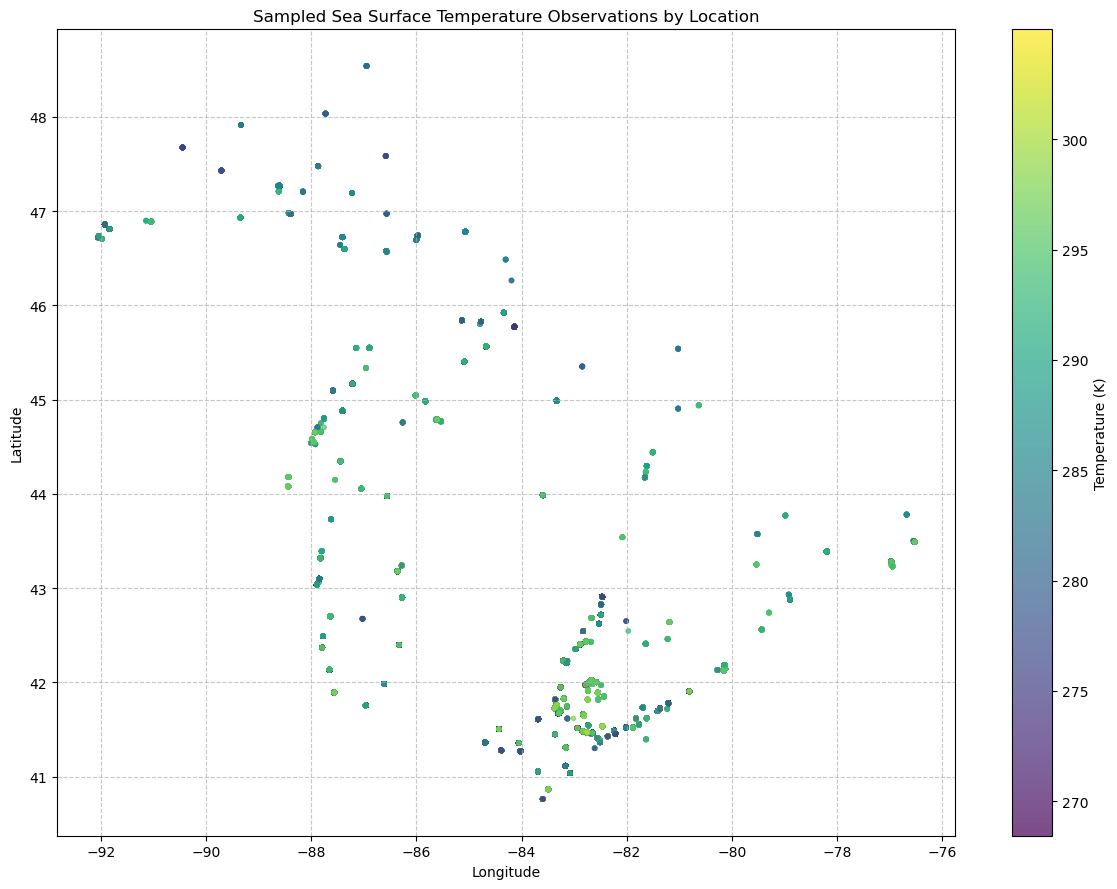

Scatter plot complete.


In [6]:
# To get a sense of the spatial coverage and temperature values,
# we'll plot a random sample of observations.
print("\nGenerating scatter plot of sampled locations...")
sample_size = 50000 # Number of points to sample (adjust as needed)

# Get random indices to sample from the 'obs' dimension
# Using pandas for sampling is efficient here
sampled_indices = pd.Series(range(len(ds.obs))).sample(n=sample_size, random_state=42)
sampled_ds = ds.isel(obs=sampled_indices.values)

plt.figure(figsize=(12, 9))
scatter = plt.scatter(sampled_ds['longitude'], sampled_ds['latitude'],
                      c=sampled_ds['temperature_k'], cmap='viridis', s=10, alpha=0.7,
                      label=f'Sampled {sample_size} Observations')
plt.colorbar(scatter, label='Temperature (K)')
plt.title('Sampled Sea Surface Temperature Observations by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Scatter plot complete.")

### 3.3 Observations by Year


Generating histogram of observations by year...


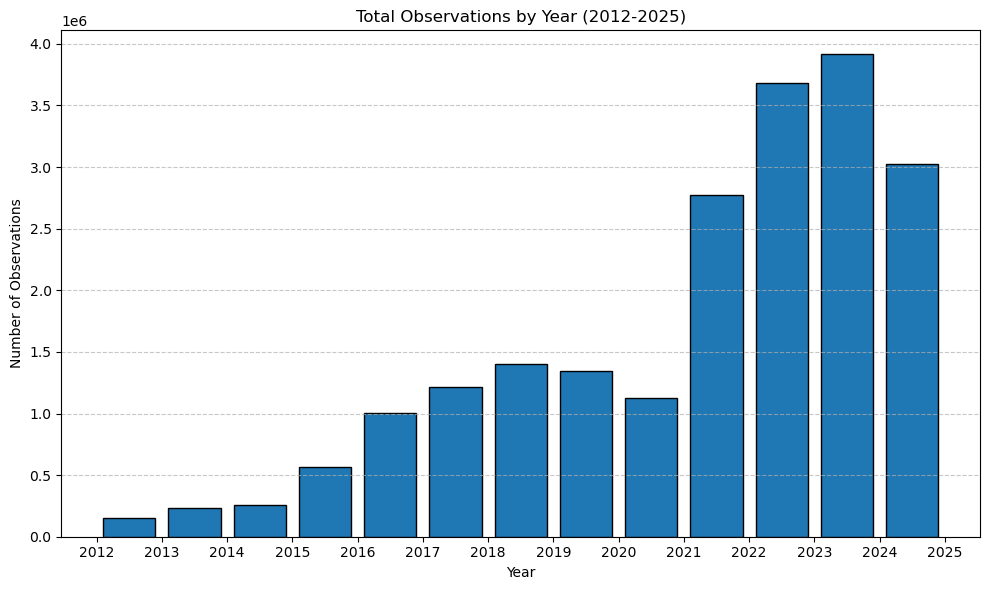

Observations by year histogram complete.


In [7]:
# Let's see how many observations there are for each year.
print("\nGenerating histogram of observations by year...")
plt.figure(figsize=(10, 6))
# Extract the year from the 'time' coordinate and plot its histogram
ds['time'].dt.year.plot.hist(bins=range(2012, 2026), rwidth=0.8, edgecolor='black')
plt.title('Total Observations by Year (2012-2025)')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.xticks(range(2012, 2026)) # Ensure all years are ticked
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Observations by year histogram complete.")